# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?

   -  Because of sparsity,what it means is it contains multiple zeros and only one value to represent a vocabulary in the corpus.
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

   - It just simply means that the word's meaning can be derived from the words near it where the word is often appeared. 


---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
%pip -q install gensim scikit-learn nltk matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [3]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\W1tcher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\W1tcher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [4]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset='train', remove=(
    "headers", "footers", "quotes"
))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [5]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower()) # YOUR CODE HERE
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # YOUR CODE HERE (filter step)

    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
    
    Because its faster since it uses less memory.

2. Name one situation where removing stopwords could be a bad idea.

    Sentiment analysis. e.g. I like this , I don't like this.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [ ]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences=corpus,
    vector_size=50,
    window=10,
    min_count=5,
    workers=4,
    
)

print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [24]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

# YOUR CODE HERE
w2v.wv['car'][:10]

array([-0.5666279 ,  0.69421357,  0.20912242, -0.29974377,  0.10686231,
       -0.75004697, -0.10413092,  0.9922711 , -0.1116868 , -0.35750052],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [25]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

results = w2v.wv.most_similar(target, topn=10)
# print(results)
# YOUR CODE HERE - iterate through the results and print each word and score

for word, score in w2v.wv.most_similar(target, topn=20):
    print(f"{word}    :   {score:.3f}")

Most similar words to 'computer':
network    :   0.929
systems    :   0.912
engineering    :   0.899
technology    :   0.894
access    :   0.884
commercial    :   0.883
currently    :   0.878
board    :   0.877
products    :   0.873
equipment    :   0.872
services    :   0.871
software    :   0.869
operating    :   0.865
digital    :   0.865
amiga    :   0.864
product    :   0.862
development    :   0.857
hardware    :   0.857
technologies    :   0.856
compatible    :   0.854


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?

    'Network' 
    
    For topic similarity it does, for functional similarity newtwork can be used in similar context in terms of function, So yeah it does reflect both topic and functional similarity.


2. Pick 1 surprising neighbor and propose a reason it might appear.

    shopper --> it might reflect digital shopping through computer may be.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [26]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
w2v.wv.most_similar(
    positive=['king', 'women'],
    negative=['man'],
    topn=10
)

[('soviet', 0.9323451519012451),
 ('republic', 0.9310782551765442),
 ('kurdish', 0.9309796690940857),
 ('empire', 0.9280510544776917),
 ('ottoman', 0.9256079196929932),
 ('exterminated', 0.9243810176849365),
 ('azerbaijan', 0.9236388802528381),
 ('germany', 0.92217618227005),
 ('former', 0.9207919836044312),
 ('committee', 0.9186282753944397)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [27]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [28]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv['king'] -w2v.wv['man'] + w2v.wv['women']
queen_vec = w2v.wv['queen']

similarity = np.dot(result_vec,queen_vec)/ (norm(result_vec)*norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.7301


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?

    because analogy can be non linear and depends on context. Also it cant capture logic only associations.


2. Give one reason analogy evaluation might not correlate with task performance.

    Because it measure whether semantic relationships are encoded linear relational structure in embeddings and may not reflect how well embeddings perform in real downstream tasks like classification or sentiment analysis.


---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

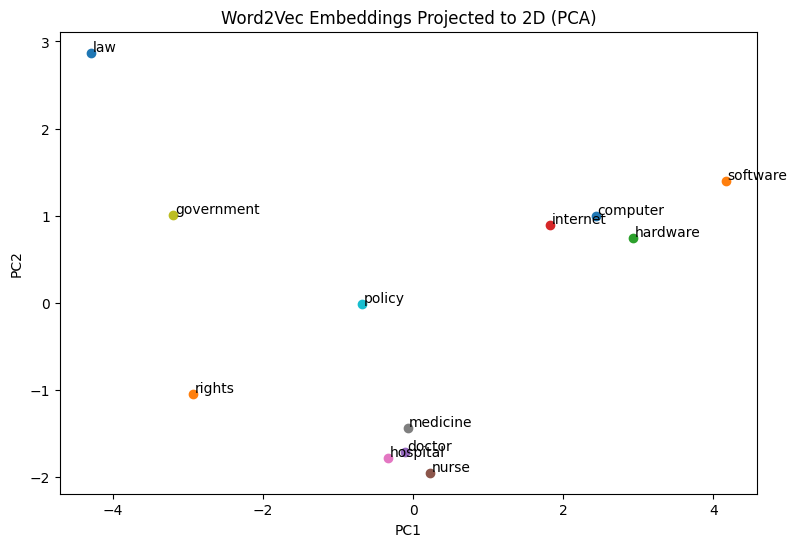

In [29]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w]for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)  # YOUR CODE HERE

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?

    - 'Doctor' and 'Hosipital'

2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

    - Yes we can see th clusters but because the sample size is less, the clusters are not clear as it should be.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [30]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)
print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [31]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
# YOUR CODE HERE

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    # YOUR CODE HERE
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers

Word2Vec neighbors for: computers


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [32]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  (word not in vocabulary)

Query: space
  (word not in vocabulary)

Query: religion
  (word not in vocabulary)

Query: graphics
  (word not in vocabulary)


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above: Motel
1. Would these neighbors help a search engine user?
    - No not realy.
2. What could go wrong if we deploy this directly in production?
    - Mismatch searches

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?

    - In terms of sparsity, One-hot vectors are most filled with zeroes which is less efficient. But embeddings are mostly filled with numbers(>0) which is dense and similar words have similar numbers. Also the vocab size is huge compared to Embeddings.

    - In terms of 'no similarity' one-hot encoders always represents zero unless its the same word. But encoding considers words similar if they are represented in similar contexts.


2. What is a realistic industry task where word embeddings are useful?

    - One example is E-commerce where user types comfortable running shoes and the product description means lightweight athletic sneakers. Embeddings helps this by searching sematic similarity rather than literal.

3. When would you choose FastText over Word2Vec?

    - Fast text is used in case of rare words, new words because it represents words using character n-grams and can generate embeddings for OOV words


4. What is one risk or limitation of word embeddings that a practitioner should watch for?


    - The one risk of word embeddings that a practitioner should watch for is Biasness.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [35]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, or None if OOV."""
    if word not in model.wv:
        return None
    return model.wv.most_similar(word, topn=topn)


def df_neighbor(model, query, topn=10, label="model"):
    """Return a neat DataFrame of neighbors."""
    result = semantic_neighbors(model, query, topn=topn)
    
    if not result:
        return pd.DataFrame({
            "model": [label], 
            "query": [query], 
            "neighbor": ["OOV"], 
            "score": [None]
        })

    df = pd.DataFrame(result, columns=["neighbor", "score"])
    
    return df.assign(model=label, query=query)[["model", "query", "neighbor", "score"]]

def train_w2v(sentences, vector_size=100, window=5, sg=1, min_count=5, workers=4, seed=42):
    """Train Word2Vec with specified params."""
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg,
        seed=seed
    )
    return model

#### Qn. 1.  Comparision of neighbors for different window size 

In [36]:
w2v_window2 = train_w2v(corpus, vector_size=100, window=2, sg=1)
w2v_window10 = train_w2v(corpus, vector_size=100, window=10, sg=1)

reulst_df = pd.concat([
    df_neighbor(w2v_window2, "technology", topn=10, label="window=2"),
    df_neighbor(w2v_window10, "technology", topn=10, label="window=10"),
], ignore_index=True)

reulst_df

,model,query,neighbor,score
0,window=2,technology,telecommunications,0.833580
1,window=2,technology,technologies,0.819722
2,window=2,technology,infrastructure,0.817604
3,window=2,technology,engineering,0.817443
4,window=2,technology,developing,0.792701
5,window=2,technology,advanced,0.791517
6,window=2,technology,aerospace,0.788628
7,window=2,technology,microcircuits,0.779119
8,window=2,technology,nren,0.772890
9,window=2,technology,management,0.766046


#### Comparing results with different vector size

In [37]:
w2v_vector50 = train_w2v(corpus, vector_size=50, window=5, sg=1)
w2v_vector200 = train_w2v(corpus, vector_size=200, window=5, sg=1)

reulst_df = pd.concat([
    df_neighbor(w2v_vector50, "technology", topn=10, label="Skip-gram vec=50"),
    df_neighbor(w2v_vector200, "technology", topn=10, label="Skip-gram vec=200"),
], ignore_index=True)

reulst_df

,model,query,neighbor,score
0,Skip-gram vec=50,technology,telecommunications,0.835582
1,Skip-gram vec=50,technology,technologies,0.834096
2,Skip-gram vec=50,technology,accelerate,0.807201
3,Skip-gram vec=50,technology,trends,0.803440
4,Skip-gram vec=50,technology,communications,0.803213
5,Skip-gram vec=50,technology,engineers,0.802573
6,Skip-gram vec=50,technology,advanced,0.799102
7,Skip-gram vec=50,technology,explore,0.798225
8,Skip-gram vec=50,technology,telephony,0.789749
9,Skip-gram vec=50,technology,infrastructure,0.789443


#### Comparision between sg = 0 (CBOW) and sg= 1(skipgram) 

In [38]:
w2v_cbow = train_w2v(corpus, vector_size=100, window=5, sg=0)
w2v_sg   = train_w2v(corpus, vector_size=100, window=5, sg=1)

reulst_df = pd.concat([
    df_neighbor(w2v_cbow, "technology", topn=10, label="CBOW (sg=0)"),
    df_neighbor(w2v_sg, "technology", topn=10, label="Skip-gram (sg=1)"),
], ignore_index=True)

reulst_df

,model,query,neighbor,score
0,CBOW (sg=0),technology,services,0.925924
1,CBOW (sg=0),technology,development,0.905809
2,CBOW (sg=0),technology,torrance,0.885638
3,CBOW (sg=0),technology,developed,0.879499
4,CBOW (sg=0),technology,telecommunications,0.870439
5,CBOW (sg=0),technology,commercial,0.867754
6,CBOW (sg=0),technology,communications,0.865642
7,CBOW (sg=0),technology,engineering,0.860423
8,CBOW (sg=0),technology,project,0.858417
9,CBOW (sg=0),technology,research,0.858242


#### Adding bigrams before training and observin changes

In [39]:
# Learn bigram phrases from the corpus
phrases = Phrases(corpus, min_count=5, threshold=10)
bigram = Phraser(phrases)

# Transform corpus into bigram-aware corpus
corpus_bi = [bigram[sent] for sent in corpus]

# Train baseline vs bigram model
w2v_base = train_w2v(corpus, vector_size=100, window=5, sg=1)
w2v_bi   = train_w2v(corpus_bi, vector_size=100, window=5, sg=1)

reulst_df = pd.concat([
    df_neighbor(w2v_base, "technology", topn=10, label="Without Bigrams"),
    df_neighbor(w2v_bi, "technology", topn=10, label="With Bigrams"),
], ignore_index=True)

reulst_df

,model,query,neighbor,score
0,Without Bigrams,technology,telecommunications,0.800627
1,Without Bigrams,technology,technologies,0.793637
2,Without Bigrams,technology,trends,0.776919
3,Without Bigrams,technology,infrastructure,0.769092
4,Without Bigrams,technology,engineers,0.760554
5,Without Bigrams,technology,accommodate,0.755573
6,Without Bigrams,technology,explore,0.747727
7,Without Bigrams,technology,advanced,0.744972
8,Without Bigrams,technology,timely,0.742434
9,Without Bigrams,technology,unprecedented,0.734251
